In [1]:
import glob
import os
import cv2
import glob
import re
import json
import h5py
import importlib

import _pickle as pkl
import matplotlib as mpl
import tifffile as tf
import pandas as pd
import pylab as pl
import seaborn as sns
import numpy as np

In [2]:
# import sys
# !conda install --yes --prefix {sys.prefix} opencv-python

In [3]:
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import analyze2p.utils as hutils
import analyze2p.retinotopy.utils as retutils
import analyze2p.plotting as pplot

import analyze2p.receptive_fields.utils as rf_utils
import analyze2p.gratings.utils as gutils
import analyze2p.gratings.bootstrap_osi as osi
import analyze2p.extraction.rois as roiutils
import analyze2p.aggregate_datasets as aggr


/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/envs/rat2pMIGR/lib/python3.8/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.5.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [4]:
import importlib
importlib.reload(aggr)

<module 'analyze2p.aggregate_datasets' from '/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/aggregate_datasets.py'>

In [5]:
def get_experiment_list(datakey, traceid='traces001', trace_type='corrected',\
                        rootdir='/n/coxfs01/2p-data'):
    session, animalid, fovn = hutils.split_datakey_str(datakey)
    
    fov_dir = glob.glob(os.path.join(rootdir, animalid, session, 'FOV%i_*' % fovn))[0]
    run_list = sorted(glob.glob(os.path.join(fov_dir, '*_run[0-9]')), 
                        key=hutils.natural_keys)
    experiment_list = list(set([os.path.split(f)[-1].split('_run')[0] \
                                for f in run_list]))
    if 'gratings' in experiment_list and (20190405 <= int(session) < 20190511):
        # Old experiment, where "gratings" were actually RFs
        experiment_list = [e for e in experiment_list if e != 'gratings']
        experiment_list.append('rfs') # These are always 5 degree res        
        
    return experiment_list

In [6]:
def aggregate_session_info(traceid='traces001', trace_type='corrected', 
                           state='awake', fov_type='zoom2p0x', 
                           visual_areas=['V1', 'Lm', 'Li'],
                           blacklist=['20190426', '20190514', '20190530'], 
                           rootdir='/n/coxfs01/2p-data'):
                           #aggregate_dir='/n/coxfs01/julianarhee/aggregate-visual-areas'):
    all_rats = [os.path.split(os.path.split(f)[0])[-1] \
                for f in glob.glob(os.path.join(rootdir, 'JC*', 'sessionmeta.json'))]
    s_list = []
    dcounter = 0
    for animalid in all_rats: 
        # Get metadata for this rat's sessions:
        with open(os.path.join(rootdir, animalid, 'sessionmeta.json'), 'r') as f:
            sessionmeta = json.load(f)
        # Get session data paths, if exist:
        for va in visual_areas:
            curr_session_list = [str(k) for k, v in sessionmeta.items()\
                                 if v['state']==state \
                                 and v['visual_area'].lower()==va.lower()]
            if len(curr_session_list) > 0:
                for s in curr_session_list:
                    session_str = s.split('_')[0]
                    fov_str = s.split('_')[-1]
                    dk = '%s_%s_fov%i' % (session_str, animalid, int(fov_str[3:]))
                    if session_str in blacklist:
                        continue
                    found_fovs = glob.glob(os.path.join(rootdir, animalid, session_str,
                                                        '%s*' % fov_str))
                    for fov_dir in found_fovs:
                        experiment_list = get_experiment_list(dk, traceid=traceid)
                        for e in experiment_list:
                            if 'dyn' in e or e=='blobs_pos' or e in ['XgratingsX', 'xblobsx']:
                                continue
                            meta_df = pd.DataFrame({
                                'visual_area': va, 
                                'animalid': animalid, 
                                'experiment': e,
                                'session': session_str,
                                'fov': '%s_%s' % (fov_str, fov_type),
                                'fovnum': int(fov_str[3:]),
                                'datakey': dk}, \
                                                   index=[dcounter])
                            dcounter += 1
                            s_list.append(meta_df)
            #else:
            #    print("[%s] %s - skipping" % (animalid, va))
    
    sessiondata = pd.concat(s_list, axis=0)
    
    return sessiondata

In [7]:
def get_dataset_info(aggregate_dir='/n/coxfs01/julianarhee/aggregate-visual-areas',
                      traceid='traces001', trace_type='corrected', state='awake',
                      fov_type='zoom2p0x', visual_areas=['V1', 'Lm', 'Li'],
                      blacklist = ['20190514', '20190530'], 
                      rootdir='/n/coxfs01/2p-data', create_new=False):
    
    dataset_info_fpath = os.path.join(aggregate_dir, 'dataset_info.pkl')
    if os.path.exists(dataset_info_fpath) and create_new is False:
        with open(dataset_info_fpath, 'rb') as f:
            sessiondata = pkl.load(f)
    else:
        sessiondata = aggregate_session_info(traceid=traceid, trace_type=trace_type, 
                                               state=state, fov_type=fov_type, 
                                               visual_areas=visual_areas,
                                               blacklist=blacklist, 
                                               rootdir=rootdir)
                                               #aggregate_dir=optsE.aggregate_dir)
                
        experiment_types = sorted(sessiondata['experiment'].unique(), key=hutils.natural_keys)
        experiment_ids = dict((exp, i) for i, exp in enumerate(experiment_types))
        animal_names = sorted(sessiondata['animalid'].unique(), key=hutils.natural_keys)
        animal_ids = dict((animal, i) for i, animal in enumerate(animal_names))
        
        sessiondata['exp_no'] = [int(experiment_ids[exp]) for exp in sessiondata['experiment']]
        sessiondata['animal_no'] = [int(animal_ids[animal]) for animal in sessiondata['animalid']]

        #%
        with open(dataset_info_fpath, 'wb') as f:
            pkl.dump(sessiondata, f, protocol=2)
    print(dataset_info_fpath)
    return sessiondata

In [8]:
#### Plotting params
visual_areas, area_colors = pplot.set_threecolor_palette()
pplot.set_plot_params(tick_labelsize=6, lw_axes=0.25)

In [9]:
#aggregate_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas'
aggregate_dir = '/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/julianarhee/aggregate-visual-areas'
rootdir = '/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-data'
response_type='dff'
traceid = 'traces001'

# Re-create session meta

In [14]:
cells_fpath = os.path.join(aggregate_dir, 'assigned_cells.pkl')
os.path.exists(cells_fpath)

True

In [15]:
'20190306_JC061_fov2' in cells['datakey'].values

True

# Load all cells (assigned)

In [16]:
importlib.reload(aggr)

<module 'analyze2p.aggregate_datasets' from '/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/aggregate_datasets.py'>

In [11]:
sdata, cells0, missing_ = aggr.get_aggregate_info(visual_areas=visual_areas, 
                                            create_new=False, #True,
                                            return_cells=True, return_missing=True,
                                            rootdir=rootdir, 
                                            aggregate_dir=aggregate_dir)
total_cell_counts = cells0[['visual_area', 'datakey', 'cell']]\
                    .drop_duplicates().groupby(['visual_area']).count().reset_index()

print(total_cell_counts)

/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/julianarhee/aggregate-visual-areas/dataset_info_assigned.pkl
Segmentation: missing 12 dsets
  visual_area  datakey  cell
0          Li     3354  3354
1          Lm     3942  3942
2          V1     4061  4061


In [12]:
counts_by_fov = cells0.groupby(['visual_area', 'datakey'])['cell'].count().reset_index()

In [13]:
# unassigned_fp = os.path.join(aggregate_dir, 'dataset_info.pkl')
# with open(unassigned_fp, 'rb') as f:
#     sdata0 = pkl.load(f, encoding='latin1')

In [14]:
# Save counts
statdir = os.path.join(aggregate_dir, 'data-stats','counts')
if not os.path.exists(statdir):
    os.makedirs(statdir)
    
# Total
total_counts_outfile = os.path.join(statdir, 'total_n_cells.csv')
total_cell_counts.to_csv (r'%s' % total_counts_outfile, index=False, header=True)

# Save N cells total by FOV
counts_by_fov_outfile = os.path.join(statdir, 'total_by_fov.csv')
counts_by_fov.to_csv(r'%s' % counts_by_fov_outfile, index=False, header=True)

# ALL
all_assigned_outfile = os.path.join(statdir, 'all_assigned_cells.csv')
cells0.to_csv (r'%s' % all_assigned_outfile, index=False, header=True)

In [15]:
all_assigned_outfile

'/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/julianarhee/aggregate-visual-areas/data-stats/counts/all_assigned_cells.csv'

# Aggregate counts

In [16]:
import analyze2p.gratings.bootstrap_osi as osi
import analyze2p.receptive_fields.utils as rfutils

In [17]:
def get_blobs_data(min_ncells=10, response_type='dff', traceid='traces001',
                    trial_epoch='stimulus', 
                    responsive_test='ROC', responsive_thr=0.05,
                   aggregate_dir = '/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/julianarhee/aggregate-visual-areas',
                   rootdir = '/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-data'):
    '''
    Gets the unique N cell count the way that objects_metrics() does 
    for data in aggregate single cell metrics figure
    '''
    NDATA0 = aggr.load_responsive_neuraldata('blobs', traceid=traceid,
                            response_type=response_type,
                            trial_epoch=trial_epoch,
                            responsive_test=responsive_test,
                            responsive_thr=responsive_thr, 
                            rootdir=rootdir, aggregate_dir=aggregate_dir)
    # count
    curr_counts = NDATA0[['visual_area', 'datakey', 'cell']].drop_duplicates()
    n_cells_all = aggr.count_n_cells(curr_counts, name='cell')
    # -----
    SDF, incorrect_stims = aggr.check_sdfs(n_cells_all['datakey'].unique(),
                          experiment='blobs', rename=True, images_only=False,
                          return_incorrect=True, return_all=False)
    # --- Get subset of FOVs that have enough cells, and correct configs
    enough_cells = [(k, v) for k, v in n_cells_all[n_cells_all['cell']>=min_ncells]\
                    [['visual_area', 'datakey']].drop_duplicates().values]
    correct_stims = SDF['datakey'].unique()
    NDATA_ = pd.concat([g for (va, dk), g in NDATA0.groupby(['visual_area', 'datakey'])\
                           if (va, dk) in enough_cells and dk in correct_stims])
    # --- Now, drop repeats
    curr_counts = NDATA_[['visual_area', 'datakey', 'cell']].drop_duplicates()\
                    .groupby(['visual_area', 'datakey']).count().reset_index()
    n_cells_all = aggr.count_n_cells(curr_counts, name='cell')

    u_dkeys = aggr.drop_repeats(n_cells_all)
    NDATA_final = pd.concat([g for (va, dk), g in NDATA_.groupby(['visual_area', 'datakey'])\
                       if (va, dk) in u_dkeys and len(g['cell'].unique())>=min_ncells])
    
    # Now count responsive
    n_responsive, _ = aggr.count_n_responsive(NDATA0, u_dkeys=u_dkeys)
    
    return NDATA_final, n_responsive, u_dkeys 
    

In [74]:
def get_gratings_data(assigned_cells, response_type='dff', traceid='traces001',
                     trial_epoch='stimulus', responsive_test='nstds',
                     responsive_thr=10., n_bootstrap_iters=500, #n_resamples=20,
                     gof_fit_thr=0.5, verbose=True, min_ncells=5,
                     aggregate_dir='/n/coxfs01/julianarhee/aggregate-visual-areas'):
    '''
    Load gratings data and counts, select unique FOVs by N fits.
    '''
    ori_fit_desc = gutils.get_fit_desc(response_type=response_type, 
                                responsive_test=responsive_test, 
                                responsive_thr=responsive_thr,
                                n_bootstrap_iters=n_bootstrap_iters)
#                                 n_resamples=n_resamples)
    gdata, no_fits, missing_fits = osi.aggregate_ori_fits(assigned_cells, 
                                    fit_desc=ori_fit_desc, 
                                    traceid=traceid, return_missing=True,
                                    rootdir=rootdir) 
    if verbose:
        print("Missing %i datasets" % len(missing_fits))
        print("{} datasets with no good fits:".format( len(no_fits)))
        for n in no_fits:
            print('    {}'.format(n))
            
    bestg = get_one_fit_per_cell(gdata)
    counts = bestg[bestg['gof']>gof_fit_thr][['visual_area', 'datakey', 'cell']].drop_duplicates()\
                .groupby(['visual_area', 'datakey']).count().reset_index()
#     u_dkeys = aggr.drop_repeats(counts)
    u_dkeys = aggr.drop_repeats(counts[counts['cell']>=min_ncells].copy())   

#     counts = gdata[gdata['gof']>gof_fit_thr][['visual_area', 'datakey', 'cell']]\
#                 .drop_duplicates()
#     u_dkeys = aggr.drop_repeats(counts)

    NDATA0 = aggr.load_responsive_neuraldata('gratings', traceid=traceid,
                                            response_type=response_type,
                                            trial_epoch=trial_epoch,
                                            responsive_test=responsive_test,
                                            responsive_thr=responsive_thr, 
                                             rootdir=rootdir,
                                             aggregate_dir=aggregate_dir)
    NDATA = pd.concat([g for (va, dk), g in NDATA0.groupby(['visual_area', 'datakey'])\
          if (va, dk) in u_dkeys])

    return NDATA, u_dkeys, gdata

def get_one_fit_per_cell(gdata_u): #, u_dkeys):
#     # Only select subset of gdata that is in our unique datakeys
#     gdata_u = pd.concat([g for (va, dk), g in gdata.groupby(['visual_area', 'datakey'])\
#           if (va, dk) in u_dkeys])
    # Get only 1 "good fit" per cell
    best_gof_ixs = gdata_u.groupby(['visual_area', 'datakey', 'cell'])['gof']\
                        .transform(max) == gdata_u['gof']
    assert gdata_u.loc[best_gof_ixs].groupby(['visual_area', 'datakey', 'cell'])\
                        .count().max().max()==1
    bestg = gdata_u.loc[best_gof_ixs].copy()
    return bestg

#### out of visually responsive cells, how many with fit tuning curves?

In [402]:
experiment='gratings'
assigned_cells, _ = aggr.select_assigned_cells(cells0, sdata, 
                                        experiments=[experiment])
    
responsive_test='ROC'
gof_fit_thr=0.5
responsive_thr=10 if responsive_test=='nstds' else 0.05
# NDATA, u_dkeys, gdata = get_gratings_data(assigned_cells, response_type='dff', traceid='traces001',
#                          trial_epoch='stimulus', responsive_test=responsive_test,
#                          responsive_thr=responsive_thr, n_bootstrap_iters=500, #n_resamples=20,
#                          verbose=True, aggregate_dir=aggregate_dir)
bestg = get_one_fit_per_cell(gdata)
# counts = bestg[bestg['gof']>gof_fit_thr][['visual_area', 'datakey', 'cell']]\
#             .drop_duplicates()
counts = bestg[bestg['gof']>gof_fit_thr][['visual_area', 'datakey', 'cell']].drop_duplicates()\
            .groupby(['visual_area', 'datakey']).count().reset_index()
u_dkeys = aggr.drop_repeats(counts)

NDATA0 = aggr.load_responsive_neuraldata('gratings', traceid=traceid,
                                        response_type=response_type,
                                        trial_epoch=trial_epoch,
                                        responsive_test=responsive_test,
                                        responsive_thr=responsive_thr, 
                                         rootdir=rootdir,
                                         aggregate_dir=aggregate_dir)
NDATA = pd.concat([g for (va, dk), g in NDATA0.groupby(['visual_area', 'datakey'])\
      if (va, dk) in u_dkeys])

/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/julianarhee/aggregate-visual-areas/dataset_info_assigned.pkl
Segmentation: missing 12 dsets
...loading: aggr_gratings_trialmeans_traces001_ROC-thr-0.05_dff_stimulus.pkl
Checking gratings configs


In [403]:
gdata[gdata['gof']>0.5][['visual_area', 'datakey', 'cell']].drop_duplicates()\
    .groupby('visual_area')['cell'].count()

visual_area
Li    167
Lm    294
V1    534
Name: cell, dtype: int64

In [404]:
# bestg = get_one_fit_per_cell(gdata, u_dkeys)
bestg.groupby(['visual_area'])['cell'].count()

visual_area
Li    409
Lm    452
V1    883
Name: cell, dtype: int64

In [405]:
NDATA[['visual_area', 'datakey', 'cell']].drop_duplicates().groupby('visual_area')['cell'].count()

visual_area
Li    255
Lm    454
V1    884
Name: cell, dtype: int64

In [407]:
counts.groupby('visual_area').sum()

,cell
visual_area,
Li,167
Lm,294
V1,534


In [411]:
bestg = get_one_fit_per_cell(gdata)
FITS = pd.concat([g for (va, dk), g in bestg.groupby(['visual_area', 'datakey'])\
          if (va, dk) in u_dkeys])
print(FITS[['visual_area', 'datakey', 'cell']].drop_duplicates()\
            .groupby(['visual_area']).count())

             datakey  cell
visual_area               
Li               238   238
Lm               441   441
V1               883   883


In [19]:
def get_rf_data(assigned_cells, rf_meta, response_type='dff', combine_rfs='average',
                do_spherical_correction=False, reliable_only=True,
                traceid='traces001', trial_epoch='stimulus', 
                responsive_test='nstds', responsive_thr=7,
               verbose=True, rootdir='/n/coxfs01/2p-data',
               aggregate_dir='/n/coxfs01/julianarhee/aggregate-visual-areas'):
#     # load fits
#     rf_fit_desc = rfutils.get_fit_desc(response_type=response_type, 
#                                     do_spherical_correction=do_spherical_correction)
#     rfdata = rfutils.aggregate_rfdata(rf_meta, assigned_cells, fit_desc=rf_fit_desc,
#                                     reliable_only=False, rootdir=rootdir)
#     # Combined rfs5/rfs10 (V1/LM, default is 5-deg; LI, default is 10-deg)
#     combined_rfs = rfutils.combine_rfs_single(rfdata) 
#     # Each cell should have only 1 value:
#     assert combined_rfs.groupby(['visual_area', 'datakey', 'cell'])['experiment']\
#         .count().max() == 1
    # Combine above steps
    rf_fit_desc = rfutils.get_fit_desc(response_type=response_type, 
                                    do_spherical_correction=do_spherical_correction)
    rfdf = rfutils.aggregate_fits(cells0, sdata, combine=combine_rfs, 
                                  response_type=response_type,
                                  do_spherical_correction=do_spherical_correction,
                                  reliable_only=reliable_only,
                                  pass_criterion='position',
                                  rootdir=rootdir)
    # Count 
    counts = rfdf[['visual_area', 'datakey', 'cell']].drop_duplicates()\
                .groupby(['visual_area', 'datakey'])['cell'].count().reset_index()
    u_dkeys = aggr.drop_repeats(counts)
    # Load all the rf data (both rfs5, rfs10)
    NDATA0 = aggr.load_responsive_neuraldata('rfs', traceid=traceid,
                                               response_type=response_type,
                                               trial_epoch=trial_epoch,
                                               responsive_test=responsive_test,
                                               responsive_thr=responsive_thr,
                                               aggregate_dir=aggregate_dir)
    # RFs may have 2 experiments (duplicate), so only keep the best one
    ucombined = pd.concat([g for (va, dk), g \
                            in rfdf.groupby(['visual_area', 'datakey'])
                            if (va, dk) in u_dkeys])
    NDATA = pd.concat([g for (va, dk, exp), g in \
            NDATA0.groupby(['visual_area', 'datakey', 'experiment']) \
            if not ucombined\
            .query('@va==visual_area and @dk==datakey')\
            .empty])
    
    return NDATA, u_dkeys, rfdf #NDATA, u_dkeys, rfdata, rfdf

In [162]:
rfs_test='nstds'; rfs_thr=7.0;
assigned_cells, rf_meta = aggr.select_assigned_cells(cells0, sdata, 
                                      experiments=['rfs', 'rfs10']) 
NDATA, u_dkeys, rfdf = get_rf_data(assigned_cells, rf_meta, response_type='dff', 
                combine_rfs='average',
                do_spherical_correction=False, reliable_only=True,
                traceid='traces001', trial_epoch='stimulus', 
                responsive_test=rfs_test, responsive_thr=rfs_thr,
                verbose=True, rootdir=rootdir,
                aggregate_dir=aggregate_dir)

N dpaths: 58, N unfit: 0
N datasets included: 63, N sessions excluded: 4
N dpaths: 58, N unfit: 0
N datasets included: 63, N sessions excluded: 4
[V1] Animalid does not exist: JC078 
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/julianarhee/aggregate-visual-areas/dataset_info_assigned.pkl
Segmentation: missing 12 dsets
...loading: aggr_rfs_trialmeans_traces001_nstds-thr-7.00_dff_stimulus.pkl
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/julianarhee/aggregate-visual-areas/dataset_info_assigned.pkl
Segmentation: missing 12 dsets
...loading: aggr_rfs10_trialmeans_traces001_nstds-thr-7.00_dff_stimulus.pkl


In [153]:
n_assigned = aggr.count_n_total(assigned_cells, rfs_dkeys)
n_assigned.groupby('visual_area').sum()

,n_total
visual_area,
Li,703
Lm,1537
V1,2529


In [130]:
NDATA[['visual_area', 'datakey', 'cell']].drop_duplicates().groupby('visual_area')['cell'].count()

visual_area
Li     473
Lm     907
V1    1260
Name: cell, dtype: int64

In [154]:
473/703

0.6728307254623044

In [155]:
907/1537

0.590110605074821

In [156]:
1260/2529

0.498220640569395

In [132]:
rfdf_u = pd.concat([g for (va, dk), g \
                        in rfdf.groupby(['visual_area', 'datakey'])
                        if (va, dk) in u_dkeys])
rfdf_u[['visual_area', 'datakey', 'cell']].drop_duplicates().groupby('visual_area')['cell'].count()

visual_area
Li    257
Lm    250
V1    748
Name: cell, dtype: int64

# Aggregate all stimuulus types

In [135]:
importlib.reload(rfutils)

<module 'analyze2p.receptive_fields.utils' from '/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/receptive_fields/utils.py'>

In [140]:
responsive_test='ROC'
responsive_thr=10 if responsive_test=='nstds' else 0.05
n_stds = 2.5
trial_epoch = 'stimulus'

blobs_test=responsive_test; blobs_thr=responsive_thr;
rfs_test='nstds'; rfs_thr=7.0;
retino_thr=0.01; retino_delay=0.5;

# Grating selection
# -----------------------------------------------------------
gratings_test=responsive_test; gratings_thr=responsive_thr;
fit_thr=0.5; n_bootstrap_iters=500; n_resamples=20;

# Output dir
dst_dir = os.path.join(aggregate_dir, 'data-stats', 'counts')
if not os.path.exists(dst_dir):
    os.makedirs(dst_dir)
data_id = '%s_%s_%s_%s-thr-%.2f' % (traceid, trial_epoch, response_type,
                                    responsive_test, responsive_thr)
print(data_id)
print(dst_dir)

traces001_stimulus_dff_ROC-thr-0.05
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/julianarhee/aggregate-visual-areas/data-stats/counts


In [141]:
FIGDIR = os.path.join(aggregate_dir, 'FIGURES', 'dataset_stats_MIGR')
if not os.path.exists(FIGDIR):
    os.makedirs(FIGDIR)

In [142]:
create_new=True
redo_retino=True # Rerun if re-made sessiondata/cells
final_counts_dfile = os.path.join(dst_dir, 'unique_counts.pkl')
if create_new is False:
    try:
        if not create_new:
            with open(final_counts_dfile, 'rb') as f:
                final_cells = pkl.load(f, encoding='latin1')
        responsive_by_stimulus = final_cells['responsive_by_stimulus']
        aggr_datakeys = final_cells['aggr_datakeys']
        COUNTS = final_cells['counts']
        # final_cells = {'responsive_by_stimulus': responsive_by_stimulus,
        #                'unique_datakeys': aggr_datakeys,
        #                'counts': COUNTS}
    except Exception as e:
        traceback.print_exc()
        create_new=True
print("NEW? %s" % str(create_new))

NEW? True


In [143]:
dst_dir = FIGDIR

In [144]:
final_counts_dfile = os.path.join(dst_dir, 'unique_counts.pkl')
print(final_counts_dfile)

/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/julianarhee/aggregate-visual-areas/FIGURES/dataset_stats_MIGR/unique_counts.pkl


# debug

In [24]:
importlib.reload(rfutils)
importlib.reload(aggr)
importlib.reload(retutils)

<module 'analyze2p.retinotopy.utils' from '/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/retinotopy/utils.py'>

In [25]:
blobs_test, blobs_thr

('ROC', 0.05)

In [26]:
responsive_test, responsive_thr, trial_epoch, response_type

('ROC', 0.05, 'stimulus', 'dff')

# Aggregate over all stimulus types

In [75]:
if create_new:
    counts_=[]
    cellids_=[]
    allcells_=[]
    ukeys_=[]
    for experiment in ['rfs', 'retino', 'gratings', 'blobs']:
        print("%s -------------------------------------" % experiment)
        if experiment in ['rfs', 'rfs10']:
#             assigned_cells, rf_meta = aggr.select_assigned_cells(cells0, sdata, 
#                                                   experiments=['rfs', 'rfs10']) 
#             NDATA, rfs_dkeys, rfdata, combined_rfs = get_rf_data(assigned_cells, rf_meta,
#                                                         response_type=response_type, 
#                                                         do_spherical_correction=False,
#                                                         reliable_only=False,
#                                                         traceid=traceid, 
#                                                         trial_epoch=trial_epoch, 
#                                                         responsive_test=rfs_test, 
#                                                         responsive_thr=rfs_thr,
#                                                     rootdir=rootdir,
#                                                     aggregate_dir=aggregate_dir)
            assigned_cells, rf_meta = aggr.select_assigned_cells(cells0, sdata, 
                                                  experiments=['rfs', 'rfs10']) 
            NDATA, rfs_dkeys, rfdf = get_rf_data(assigned_cells, rf_meta, response_type='dff', 
                            combine_rfs='average',
                            do_spherical_correction=False, reliable_only=True,
                            traceid=traceid, trial_epoch=trial_epoch, 
                            responsive_test=rfs_test, responsive_thr=rfs_thr,
                            verbose=True, rootdir=rootdir,
                            aggregate_dir=aggregate_dir)
            n_responsive = aggr.count_n_cells(NDATA, name='n_responsive')
            n_total = aggr.count_n_total(assigned_cells, rfs_dkeys)
            u_dkeys = rfs_dkeys
        elif experiment=='retino':
            #retino_thr=0.01; retino_delay=0.5; 
            redo_retino=False
            assigned_cells, ret_meta = aggr.select_assigned_cells(cells0, 
                                                        sdata, experiments=['retino'])
            NDATA = aggr.load_responsive_neuraldata(experiment, traceid=traceid,
                                        retino_thr=retino_thr, retino_delay=retino_delay,
                                        redo_retino=redo_retino,
                                        aggregate_dir=aggregate_dir)
            # Get unique dkeys and count
            n_responsive, retino_dkeys = aggr.count_n_responsive(NDATA, u_dkeys=None)
            n_total = aggr.count_n_total(assigned_cells, retino_dkeys)
            u_dkeys = retino_dkeys
        if experiment=='gratings':
            NDATA, gratings_dkeys, gdata = get_gratings_data(assigned_cells, 
                                    response_type=response_type, traceid=traceid,
                                    trial_epoch=trial_epoch, responsive_test=responsive_test,
                                    responsive_thr=responsive_thr, 
                                    n_bootstrap_iters=500, #n_resamples=20,
                                    verbose=True, aggregate_dir=aggregate_dir)
            # Get unique dkeys and count
            n_responsive, _ = aggr.count_n_responsive(NDATA, u_dkeys=gratings_dkeys)
            n_total = aggr.count_n_total(assigned_cells, gratings_dkeys)
            u_dkeys = gratings_dkeys
            
        elif experiment=='blobs': # or experiment=='gratings':
            assigned_cells, _ = aggr.select_assigned_cells(cells0, sdata, 
                                                    experiments=[experiment])
#             NDATA = aggr.load_responsive_neuraldata(experiment, traceid=traceid,
#                                                    response_type=response_type,
#                                                    trial_epoch=trial_epoch,
#                                                    responsive_test=blobs_test,
#                                                    responsive_thr=blobs_thr,
#                                                     rootdir=rootdir,
#                                                    aggregate_dir=aggregate_dir)
#             # Get unique dkeys and count
#             n_responsive, blobs_dkeys = aggr.count_n_responsive(NDATA, u_dkeys=None)
#             NDATA, n_responsive, blobs_dkeys = get_blobs_data(NDATA0, min_ncells=min_ncells)
            NDATA, n_responsive, blobs_dkeys = get_blobs_data(min_ncells=10, 
                            response_type=response_type, traceid=traceid,
                            trial_epoch=trial_epoch, 
                            responsive_test=responsive_test, responsive_thr=responsive_thr,
                            aggregate_dir=aggregate_dir, rootdir=rootdir)
             
            # More counts
            n_total = aggr.count_n_total(assigned_cells, blobs_dkeys)
            u_dkeys = blobs_dkeys
            
        # Check counts
        found_none = [(va, k) for (va,k) in n_total[['visual_area', 'datakey']].values \
             if n_responsive.query('@va==visual_area and @k==datakey').empty]
        cols=['visual_area', 'datakey', 'n_responsive']
        for (va_n, dk_n) in found_none:
            n_responsive.loc[len(n_responsive.index), cols] = [va_n, dk_n, 0]

        # Add total counts
        assert n_total.shape==n_responsive.shape, \
                'Incorrect counts: total=%i, responsive=%i' \
                % (n_total.shape[0], n_responsive.shape[0])
        counts = pd.merge(n_responsive, n_total)
        counts['fraction_responsive'] = counts['n_responsive']/counts['n_total'].astype(float)
        counts['stimulus'] = experiment
        counts_.append(counts)
        # Add cell IDs (responsive)
        cellids = NDATA[['visual_area', 'datakey', 'cell']].drop_duplicates().copy()
        cellids['stimulus'] = experiment
        cellids_.append(cellids)
        incl_cells = pd.concat([assigned_cells.query('@va==visual_area and @dk==datakey')
                        for (va, dk), g in NDATA.groupby(['visual_area', 'datakey'])])
        allcells_.append(incl_cells[['visual_area', 'datakey', 'cell']])
        # Save which datasets included (unique)
        unique_keys = pd.DataFrame(u_dkeys).rename(\
                                            columns={0:'visual_area', 1: 'datakey'})
        unique_keys['stimulus'] = experiment
        ukeys_.append(unique_keys)

    # All unique datakeys
    aggr_datakeys = pd.concat(ukeys_, axis=0) # Included datasets (unique dkeys)
    # Responsive cells
    responsive_by_stimulus = pd.concat(cellids_, axis=0) # Cell IDs of counted cells
    counts_by_stimulus = pd.concat(counts_, axis=0) # Counts (1 # per dataset)
    # Responsive to ANYTHING
    responsive_cells = responsive_by_stimulus[['visual_area', 'datakey', 'cell']].drop_duplicates()
    any_counts = aggr.count_n_cells(responsive_cells, name='n_responsive')
    any_counts.groupby(['visual_area']).describe()
    # ALL assigned cells
    all_cells = pd.concat(allcells_, axis=0).reset_index(drop=True) # ALL assigned cells
    all_counts = aggr.count_n_cells(all_cells, name='n_total')
    all_counts.groupby(['visual_area']).describe()
    # Combine ALL cells and RESPONSIVE cells
    assert any_counts.shape==all_counts.shape
    total_counts = pd.merge(any_counts, all_counts, on=['visual_area', 'datakey'],
                           how='outer')
    total_counts['fraction_responsive'] = total_counts['n_responsive']/total_counts['n_total'].astype(float)
    total_counts['stimulus'] = 'any'
    total_counts.head()
    # ALL CELLS
    COUNTS = pd.concat([counts_by_stimulus, total_counts], axis=0)
    print(counts_by_stimulus.shape, total_counts.shape, COUNTS.shape)
    print(counts_by_stimulus.shape[0]+total_counts.shape[0])
    # SAVE.
    final_cells = {'responsive_by_stimulus': responsive_by_stimulus,
                   'unique_datakeys': aggr_datakeys,
                   'counts': COUNTS}
    with open(final_counts_dfile, 'wb') as f:
        pkl.dump(final_cells, f, protocol=2)
    print(final_counts_dfile)

rfs -------------------------------------
N dpaths: 58, N unfit: 0
N datasets included: 63, N sessions excluded: 4
N dpaths: 58, N unfit: 0
N datasets included: 63, N sessions excluded: 4
[V1] Animalid does not exist: JC078 
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/julianarhee/aggregate-visual-areas/dataset_info_assigned.pkl
Segmentation: missing 12 dsets
...loading: aggr_rfs_trialmeans_traces001_nstds-thr-7.00_dff_stimulus.pkl
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/julianarhee/aggregate-visual-areas/dataset_info_assigned.pkl
Segmentation: missing 12 dsets
...loading: aggr_rfs10_trialmeans_traces001_nstds-thr-7.00_dff_stimulus.pkl
retino -------------------------------------
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/julianarhee/aggregate-visual-areas/dataset_info_assigned.pkl
Segmentation: missing 12 dsets
Aggregating retinodata and saving
[V1] Animalid does not exist: JC078 
gratings -------------------------------------
Missing 32 datasets
2 datasets with no good fits:
    Lm_201

In [99]:
COUNTS = pd.concat([counts_by_stimulus, total_counts], axis=0)

<IPython.core.display.Javascript object>


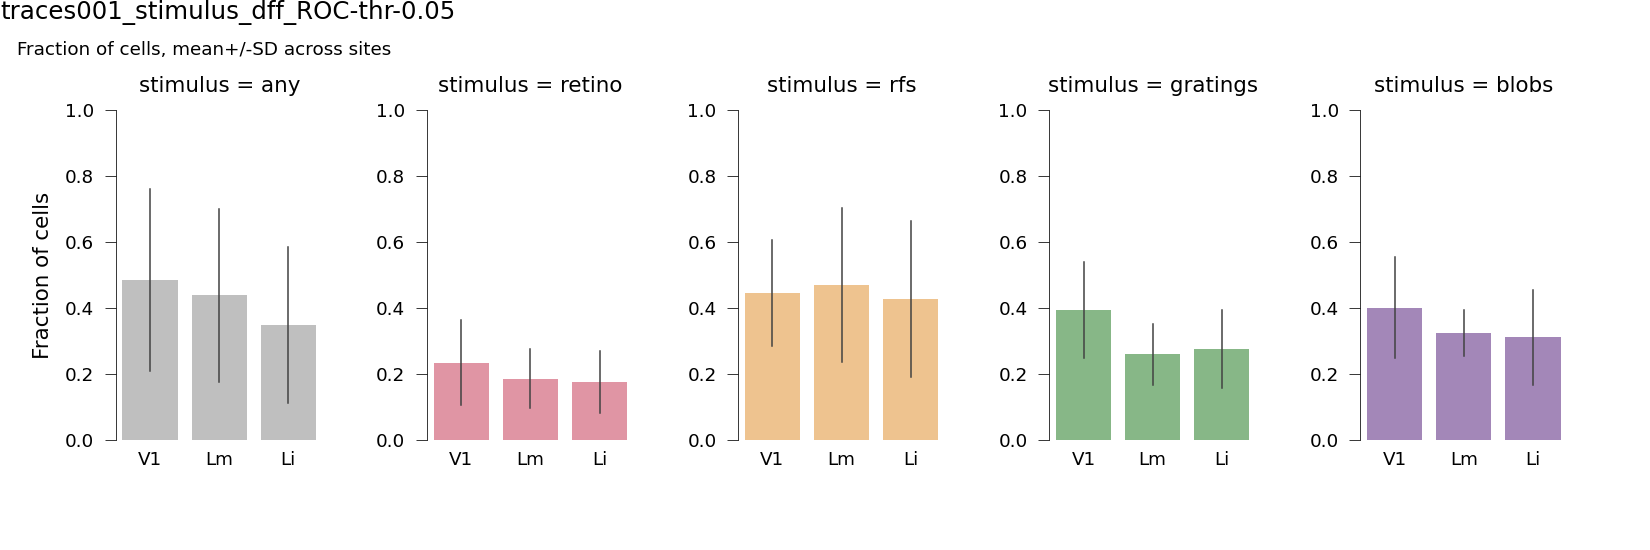

/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/julianarhee/aggregate-visual-areas/data-stats/counts fraction_responsive_test-ROC-thr-0
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/julianarhee/aggregate-visual-areas/FIGURES/dataset_stats_MIGR fraction_responsive_test-ROC-thr-0


In [100]:
%matplotlib notebook
e_colors = {'retino': 'crimson', 'rfs': 'darkorange', 
            'gratings': 'green', 'blobs': 'indigo',
            'any': 'gray'}

fg = sns.FacetGrid(col='stimulus', data=COUNTS, height=2.5, aspect=0.6,
                  col_order=['any', 'retino', 'rfs', 'gratings', 'blobs'],
                  hue='stimulus', palette=e_colors) #'colorblind')
fg.map(sns.barplot, 'visual_area', 'fraction_responsive', 
         order=visual_areas, ci='sd', alpha=0.5, errwidth=0.5)

sns.despine(bottom=True)

for ai, ax in enumerate(fg.axes.flat):
    ax.set_xlabel('')
    ax.tick_params(which='both', axis='x', size=0)
    ax.tick_params(labelleft=True)
    ax.set_ylim([0, 1])
    if ai==0 or ai==1:
        ax.set_ylabel('Fraction of cells')
    #ax.set_box_aspect(2)
pl.subplots_adjust(left=0.07, right=0.95, bottom=0.2, top=0.8, wspace=0.5)
fg.fig.text(0.01, 0.9, 'Fraction of cells, mean+/-SD across sites')

pplot.label_figure(fg.fig, data_id)
figname = 'fraction_responsive_test-%s-thr-%i' % (gratings_test, gratings_thr)
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(dst_dir, figname)

# FIGDIR = os.path.join(aggregate_dir, 'FIGURES')
pl.savefig(os.path.join(FIGDIR, '%s.svg' % figname))
print(FIGDIR, figname)

## Count fits - gratings

In [90]:
def get_fraction_fit(cnts_rf, rfdf, rfs_dkeys):
    
    rfdf_u = pd.concat([g for (va, dk), g \
                            in rfdf.groupby(['visual_area', 'datakey'])
                            if (va, dk) in rfs_dkeys])
    # rfdf_u[['visual_area', 'datakey', 'cell']].drop_duplicates().groupby('visual_area')['cell'].count()
    n_fits_rf = rfdf_u[['visual_area', 'datakey', 'cell']].drop_duplicates()\
                    .groupby(['visual_area', 'datakey'])['cell'].count().reset_index()\
                    .rename(columns={'cell': 'n_fit'})
    
    assert cnts_rf.shape[0]==n_fits_rf.shape[0], 'incorrect cell counts'
    COUNTS_rf = pd.merge(cnts_rf, n_fits_rf, on=['visual_area', 'datakey'])
    COUNTS_rf['fraction_fit_over_responsive'] = COUNTS_rf['n_fit']/COUNTS_rf['n_responsive']
    COUNTS_rf['fraction_fit'] = COUNTS_rf['n_fit']/COUNTS_rf['n_total']
    return COUNTS_rf

In [103]:
COUNTS_rf = get_fraction_fit(COUNTS[COUNTS['stimulus']=='rfs'], rfdf, rfs_dkeys)

gof_thr=0.5
COUNTS_gf = get_fraction_fit(COUNTS[COUNTS['stimulus']=='gratings'], 
                             gdata[gdata['gof']>gof_thr], gratings_dkeys)

In [109]:
COUNTS_gf.groupby('visual_area')['fraction_fit_over_responsive'].describe()

,count,mean,std,min,25%,50%,75%,max
visual_area,,,,,,,,
Li,7.0,0.455461,0.109350,0.333333,0.387874,0.454545,0.478968,0.666667
Lm,7.0,0.605979,0.178214,0.243902,0.589572,0.592105,0.725000,0.776699
V1,8.0,0.587538,0.106369,0.444444,0.510330,0.598116,0.648613,0.752475


In [ ]:
# bestg = get_one_fit_per_cell(gdata, gratings_dkeys)
# # bestg.groupby(['visual_area'])['cell'].count()
# # rfdf_u[['visual_area', 'datakey', 'cell']].drop_duplicates().groupby('visual_area')['cell'].count()
# n_fits_gratings = bestg[['visual_area', 'datakey', 'cell']].drop_duplicates()\
#                 .groupby(['visual_area', 'datakey'])['cell'].count().reset_index()\
#                 .rename(columns={'cell': 'n_fit'})

# Get table of counts for all experiment types

In [110]:
COUNTS.loc[COUNTS['stimulus']=='rfs', 'n_fit'] = COUNTS_rf['n_fit']
COUNTS.loc[COUNTS['stimulus']=='rfs', 'fraction_fit'] = COUNTS_rf['fraction_fit']
COUNTS.loc[COUNTS['stimulus']=='rfs', 'fraction_fit_over_responsive'] = COUNTS_rf['fraction_fit_over_responsive']

COUNTS.loc[COUNTS['stimulus']=='gratings', 'n_fit'] = COUNTS_gf['n_fit']
COUNTS.loc[COUNTS['stimulus']=='gratings', 'fraction_fit'] = COUNTS_gf['fraction_fit']
COUNTS.loc[COUNTS['stimulus']=='gratings', 'fraction_fit_over_responsive'] = COUNTS_gf['fraction_fit_over_responsive']

<IPython.core.display.Javascript object>


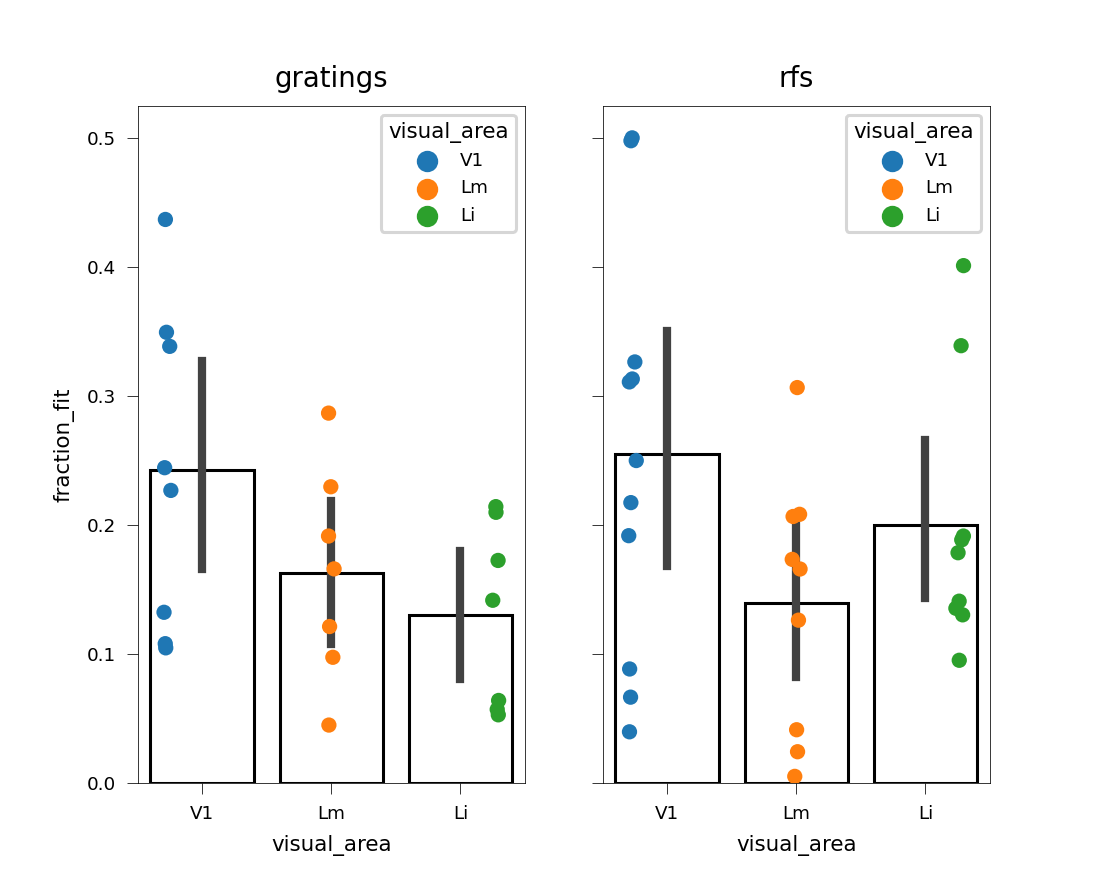

In [111]:
curr_exps = ['rfs', 'gratings']
# min_nfit = 5
final_counts = COUNTS[COUNTS['stimulus'].isin(curr_exps)]

fig, axn = pl.subplots(1, 2, sharex=True, sharey=True)

for ai, (exp, cnts) in enumerate(final_counts.groupby('stimulus')):
    sns.stripplot(data=cnts, y='fraction_fit', ax=axn[ai],
              x='visual_area', order=['V1', 'Lm', 'Li'], dodge=True,
              hue='visual_area', hue_order=['V1', 'Lm', 'Li'])
    sns.barplot(data=cnts, y='fraction_fit', ax=axn[ai],
              x='visual_area', order=['V1', 'Lm', 'Li'], dodge=True,
                edgecolor='k', facecolor='none')
    axn[ai].set_title(exp)

# Save final output

In [145]:
# SAVE.
final_cells = {'responsive_by_stimulus': responsive_by_stimulus,
               'unique_datakeys': aggr_datakeys,
               'counts': COUNTS}
with open(final_counts_dfile, 'wb') as f:
    pkl.dump(final_cells, f, protocol=2)
print(final_counts_dfile)

/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/julianarhee/aggregate-visual-areas/FIGURES/dataset_stats_MIGR/unique_counts.pkl


In [148]:

# Total
total_counts_outfile = os.path.join(FIGDIR, 'total_n_cells.csv')
total_cell_counts.to_csv (r'%s' % total_counts_outfile, index=False, header=True)

# Save N cells total by FOV
counts_by_fov_outfile = os.path.join(FIGDIR, 'total_by_fov.csv')
counts_by_fov.to_csv(r'%s' % counts_by_fov_outfile, index=False, header=True)

# ALL
all_assigned_outfile = os.path.join(FIGDIR, 'all_assigned_cells.csv')
cells0.to_csv (r'%s' % all_assigned_outfile, index=False, header=True)

counts_outfile = os.path.join(FIGDIR, 'COUNTS.csv')
COUNTS.to_csv (r'%s' % counts_outfile, index=False, header=True)

## Print counts

In [53]:
COUNTS[(COUNTS['stimulus']=='blobs')].groupby('visual_area')['n_responsive'].sum()

visual_area
Li     247
Lm     531
V1    1010
Name: n_responsive, dtype: int64

In [130]:
# min_ncells=10
describe_cols = ['visual_area', 'count', 'mean', 'std', 'min', 'max']
stimulus = 'blobs'
for stimulus, curr_counts in COUNTS.groupby('stimulus'):
    cnts_ =  curr_counts.groupby('visual_area')['n_responsive']\
                .describe().reset_index()[describe_cols]\
                .rename(columns={'count': 'n_fov', 
                                'mean': 'mean_n_cells',
                                'std': 'std_n_cells',
                                'min': 'min_n_cells',
                                'max': 'max_n_cells'})
    n_resp = COUNTS[(COUNTS['stimulus']==stimulus)]\
                .groupby('visual_area')['n_responsive'].sum().reset_index()
    n_total = COUNTS[(COUNTS['stimulus']==stimulus)]\
                .groupby('visual_area')['n_total'].sum().reset_index()
    n_ = pd.merge(n_total, n_resp, on=['visual_area'])
    n_['stimulus'] = stimulus
    curr_counts = pd.merge(n_, cnts_)
    print("{}--------------------------------------".format(stimulus))
    display(curr_counts)

any--------------------------------------


,visual_area,n_total,n_responsive,stimulus,n_fov,mean_n_cells,std_n_cells,min_n_cells,max_n_cells
0,Li,3106,983,any,24.0,40.958333,36.286875,4.0,161.0
1,Lm,3936,1858,any,20.0,92.900000,73.734874,2.0,278.0
2,V1,4061,2242,any,19.0,118.000000,113.076670,4.0,344.0


blobs--------------------------------------


,visual_area,n_total,n_responsive,stimulus,n_fov,mean_n_cells,std_n_cells,min_n_cells,max_n_cells
0,Li,909,247,blobs,6.0,41.166667,9.703951,29.0,52.0
1,Lm,1601,531,blobs,8.0,66.375000,30.504976,22.0,120.0
2,V1,2499,1010,blobs,9.0,112.222222,65.828903,13.0,196.0


gratings--------------------------------------


,visual_area,n_total,n_responsive,stimulus,n_fov,mean_n_cells,std_n_cells,min_n_cells,max_n_cells
0,Li,837,219,gratings,7.0,31.285714,21.383126,9.0,72.0
1,Lm,1668,454,gratings,7.0,64.857143,32.600760,30.0,110.0
2,V1,2306,883,gratings,8.0,110.375000,52.573588,18.0,186.0


retino--------------------------------------


,visual_area,n_total,n_responsive,stimulus,n_fov,mean_n_cells,std_n_cells,min_n_cells,max_n_cells
0,Li,1877,269,retino,17.0,15.823529,9.349033,4.0,41.0
1,Lm,2772,515,retino,14.0,36.785714,25.899743,12.0,102.0
2,V1,2725,665,retino,10.0,66.500000,47.675407,5.0,140.0


rfs--------------------------------------


,visual_area,n_total,n_responsive,stimulus,n_fov,mean_n_cells,std_n_cells,min_n_cells,max_n_cells
0,Li,1299,473,rfs,9.0,52.555556,37.848749,16.0,143.0
1,Lm,1798,907,rfs,9.0,100.777778,77.119676,15.0,278.0
2,V1,2755,1260,rfs,11.0,114.545455,75.534580,4.0,222.0


In [128]:
curr_counts

,visual_area,n_total,n_responsive,stimulus,n_fov,mean_n_cells,std_n_cells,min_n_cells,max_n_cells
0,Li,909,247,blobs,6.0,41.166667,9.703951,29.0,52.0
1,Lm,1601,531,blobs,8.0,66.375000,30.504976,22.0,120.0
2,V1,2499,1010,blobs,9.0,112.222222,65.828903,13.0,196.0


In [133]:
for stimulus, fitdf in COUNTS.groupby('stimulus'):
    if len(fitdf.dropna())==0:
        continue
    print("{}--------------------------------------".format(stimulus))
    #final_gratings = final_counts[final_counts['stimulus']=='gratings']
    display(fitdf.groupby('visual_area')['fraction_fit_over_responsive'].describe())

gratings--------------------------------------


,count,mean,std,min,25%,50%,75%,max
visual_area,,,,,,,,
Li,7.0,0.455461,0.109350,0.333333,0.387874,0.454545,0.478968,0.666667
Lm,7.0,0.605979,0.178214,0.243902,0.589572,0.592105,0.725000,0.776699
V1,8.0,0.587538,0.106369,0.444444,0.510330,0.598116,0.648613,0.752475


rfs--------------------------------------


,count,mean,std,min,25%,50%,75%,max
visual_area,,,,,,,,
Li,9.0,0.514198,0.144993,0.243243,0.478261,0.557692,0.615385,0.666667
Lm,9.0,0.302077,0.226178,0.064103,0.076087,0.345133,0.428571,0.655914
V1,11.0,0.602018,0.316336,0.087379,0.412267,0.635135,0.753551,1.250000


In [134]:
dst_dir

'/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/julianarhee/aggregate-visual-areas/data-stats/counts'

In [212]:
COUNTS[COUNTS['stimulus']=='any']\
        .groupby(['visual_area', 'datakey'], as_index=False)['n_total'].sum()

,visual_area,datakey,n_total
0,Li,20190314_JC070_fov1,137
1,Li,20190315_JC070_fov1,135
2,Li,20190315_JC070_fov2,102
3,Li,20190316_JC070_fov1,152
4,Li,20190319_JC067_fov1,31
...,...,...,...
60,V1,20190617_JC097_fov1,438
61,V1,20190622_JC085_fov1,312
62,V1,20191004_JC110_fov2,363
63,V1,20191006_JC110_fov1,391


In [38]:
COUNTS['stimulus'].unique()

array(['rfs', 'retino', 'gratings', 'blobs', 'any'], dtype=object)

In [45]:
COUNTS.columns

Index(['visual_area', 'datakey', 'n_responsive', 'n_total',
       'fraction_responsive', 'stimulus'],
      dtype='object')

In [68]:
COUNTS['animal'] = [b.split('_')[1] for b in COUNTS['datakey']]
COUNTS.head()

,visual_area,datakey,n_responsive,n_total,fraction_responsive,stimulus,animal
0,Li,20190522_JC089_fov1,10,28,0.357143,rfs,JC089
1,Li,20190527_JC092_fov3,65,118,0.550847,rfs,JC092
2,Li,20190528_JC092_fov1,37,47,0.787234,rfs,JC092
3,Li,20190602_JC091_fov1,103,197,0.522843,rfs,JC091
4,Li,20190612_JC099_fov1,54,164,0.329268,rfs,JC099


In [69]:
min_ncells = 10
COUNTS_thr = COUNTS[COUNTS['n_responsive']>=min_ncells].copy()


In [70]:
COUNTS_thr.groupby('stimulus')['n_responsive'].min()

stimulus
any         10
blobs       22
gratings    10
retino      11
rfs         10
Name: n_responsive, dtype: int64

In [71]:
COUNTS_thr[COUNTS_thr['stimulus']=='rfs']\
        .groupby(['visual_area', 'datakey'], as_index=False)['n_total'].sum()

,visual_area,datakey,n_total
0,Li,20190522_JC089_fov1,28
1,Li,20190527_JC092_fov3,118
2,Li,20190528_JC092_fov1,47
3,Li,20190602_JC091_fov1,197
4,Li,20190612_JC099_fov1,164
5,Li,20190614_JC091_fov1,299
6,Li,20190617_JC099_fov1,78
7,Li,20191017_JC113_fov1,214
8,Li,20191106_JC120_fov1,189
9,Lm,20190430_JC078_fov1,285


In [72]:
for stim, cnts in COUNTS_thr.groupby('stimulus'):
    print(f"{stim}")
    print(cnts.groupby(['visual_area'], as_index=False)['datakey'].nunique()) #sum()

any
  visual_area  datakey
0          Li       23
1          Lm       19
2          V1       18
blobs
  visual_area  datakey
0          Li        8
1          Lm        9
2          V1        9
gratings
  visual_area  datakey
0          Li        9
1          Lm        7
2          V1        8
retino
  visual_area  datakey
0          Li       12
1          Lm       14
2          V1        9
rfs
  visual_area  datakey
0          Li        9
1          Lm        9
2          V1       10


In [73]:
for stim, cnts in COUNTS_thr.groupby('stimulus'):
    print(f"{stim}")
    print(cnts.groupby(['stimulus', 'visual_area'], as_index=True)['n_responsive'].describe()) #sum()

any
                      count        mean        std   min    25%    50%    75%  \
stimulus visual_area                                                            
any      Li            23.0   53.739130  40.680817  11.0  28.00   39.0   71.0   
         Lm            19.0  106.000000  74.059286  18.0  36.00  105.0  145.5   
         V1            18.0  132.388889  98.146433  10.0  37.25  131.5  188.0   

                        max  
stimulus visual_area         
any      Li           162.0  
         Lm           280.0  
         V1           327.0  
blobs
                      count        mean        std   min    25%    50%    75%  \
stimulus visual_area                                                            
blobs    Li             8.0   47.375000  23.542894  22.0  29.75   42.5   55.5   
         Lm             9.0   71.333333  39.645302  22.0  41.00   66.0   97.0   
         V1             9.0  114.555556  63.271461  25.0  86.00  107.0  182.0   

                        max 

In [80]:
nrats = COUNTS_thr.groupby(['stimulus', 'visual_area']).nunique()[['animal', 'datakey']]
nrats

animal  datakey
stimulus visual_area                 
any      Li               10       23
         Lm               11       19
         V1                8       18
blobs    Li                7        8
         Lm                8        9
         V1                6        9
gratings Li                6        9
         Lm                7        7
         V1                5        8
retino   Li                9       12
         Lm               11       14
         V1                7        9
rfs      Li                6        9
         Lm                7        9
         V1                7       10

In [83]:
COUNTS_thr.groupby(['stimulus', 'visual_area']).sum()

n_responsive  n_total  fraction_responsive
stimulus visual_area                                            
any      Li                   1236     3187             9.212619
         Lm                   2014     3866             9.546797
         V1                   2383     3999            10.266325
blobs    Li                    379     1303             2.452270
         Lm                    642     1711             3.203236
         V1                   1031     2540             3.653614
gratings Li                    306     1327             2.066326
         Lm                    455     1664             1.826001
         V1                    883     2306             3.154300
retino   Li                    234     1622             2.129884
         Lm                    515     2768             2.597513
         V1                    660     2684             2.220964
rfs      Li                    465     1334             3.522510
         Lm                    883     1788             4.121307
         V1                   1037     2624             4.141827

In [54]:
count_stats_thr = COUNTS_thr.groupby(['stimulus', 'visual_area'], as_index=True)['n_responsive'].describe() #sum()
count_stats = COUNTS.groupby(['stimulus', 'visual_area'], as_index=True)['n_responsive'].describe() #sum()

In [65]:
nrois_stats_thr = COUNTS_thr.groupby(['stimulus', 'visual_area'], as_index=True)['n_total'].describe() #sum()
nrois_stats_thr

count        mean         std    min     25%    50%  \
stimulus visual_area                                                        
any      Li            23.0  138.565217   71.632792   28.0   88.00  137.0   
         Lm            19.0  203.473684   67.815410   72.0  170.50  202.0   
         V1            18.0  222.166667  136.163073   34.0   99.00  225.5   
blobs    Li             8.0  162.875000   67.878963   81.0  125.00  157.5   
         Lm             9.0  190.111111   70.806858   73.0  169.00  193.0   
         V1             9.0  282.222222  122.346616   74.0  225.00  260.0   
gratings Li             9.0  147.444444   68.911376   78.0  102.00  137.0   
         Lm             7.0  237.714286   42.252078  172.0  212.00  235.0   
         V1             8.0  288.250000  129.816079   74.0  212.25  286.0   
retino   Li            12.0  135.166667   71.118126   31.0   85.00  143.5   
         Lm            14.0  197.714286   72.944055   72.0  169.75  211.0   
         V1             9.0  298.222222   99.321168  174.0  226.00  260.0   
rfs      Li             9.0  148.222222   87.959902   28.0   78.00  164.0   
         Lm             9.0  198.666667   63.025788   72.0  172.00  193.0   
         V1            10.0  262.400000  106.141624   57.0  225.25  243.0   

                         75%    max  
stimulus visual_area                 
any      Li           178.00  299.0  
         Lm           270.00  285.0  
         V1           329.25  438.0  
blobs    Li           185.00  299.0  
         Lm           235.00  285.0  
         V1           391.00  438.0  
gratings Li           164.00  299.0  
         Lm           275.00  283.0  
         V1           401.25  438.0  
retino   Li           176.50  280.0  
         Lm           260.50  285.0  
         V1           391.00  438.0  
rfs      Li           197.00  299.0  
         Lm           235.00  285.0  
         V1           329.25  438.0

In [56]:
count_stats_thr

count        mean        std   min    25%    50%  \
stimulus visual_area                                                     
any      Li            23.0   53.739130  40.680817  11.0  28.00   39.0   
         Lm            19.0  106.000000  74.059286  18.0  36.00  105.0   
         V1            18.0  132.388889  98.146433  10.0  37.25  131.5   
blobs    Li             8.0   47.375000  23.542894  22.0  29.75   42.5   
         Lm             9.0   71.333333  39.645302  22.0  41.00   66.0   
         V1             9.0  114.555556  63.271461  25.0  86.00  107.0   
gratings Li             9.0   34.000000  21.627529  10.0  20.00   24.0   
         Lm             7.0   65.000000  32.444825  30.0  38.00   60.0   
         V1             8.0  110.375000  52.573588  18.0  90.50   99.5   
retino   Li            12.0   19.500000   8.691689  11.0  14.00   17.0   
         Lm            14.0   36.785714  25.899743  12.0  18.00   26.5   
         V1             9.0   73.333333  45.074938  15.0  38.00   70.0   
rfs      Li             9.0   51.666667  34.824560  10.0  27.00   37.0   
         Lm             9.0   98.111111  78.202373  15.0  59.00   90.0   
         V1            10.0  103.700000  60.214524  16.0  68.75   99.0   

                         75%    max  
stimulus visual_area                 
any      Li            71.00  162.0  
         Lm           145.50  280.0  
         V1           188.00  327.0  
blobs    Li            55.50   87.0  
         Lm            97.00  143.0  
         V1           182.00  196.0  
gratings Li            50.00   72.0  
         Lm            89.50  110.0  
         V1           139.50  186.0  
retino   Li            23.75   41.0  
         Lm            53.00  102.0  
         V1           118.00  140.0  
rfs      Li            65.00  109.0  
         Lm           113.00  278.0  
         V1           139.50  221.0

In [63]:
fraction_stats_thr = COUNTS_thr.groupby([
    'stimulus', 'visual_area'], as_index=True)['fraction_responsive'].describe() #sum()
fraction_stats_thr

count      mean       std       min       25%       50%  \
stimulus visual_area                                                            
any      Li            23.0  0.400549  0.200744  0.137255  0.219307  0.378571   
         Lm            19.0  0.502463  0.249783  0.066914  0.354708  0.498208   
         V1            18.0  0.570351  0.209778  0.159292  0.452746  0.569684   
blobs    Li             8.0  0.306534  0.139909  0.162963  0.207127  0.276776   
         Lm             9.0  0.355915  0.100657  0.235849  0.301370  0.343860   
         V1             9.0  0.405957  0.153776  0.146018  0.337838  0.415525   
gratings Li             9.0  0.229592  0.111449  0.098039  0.160584  0.179487   
         Lm             7.0  0.260857  0.090770  0.173267  0.179552  0.255319   
         V1             8.0  0.394287  0.146279  0.223744  0.239338  0.417500   
retino   Li            12.0  0.177490  0.093629  0.058201  0.120201  0.167502   
         Lm            14.0  0.185537  0.089577  0.063492  0.116724  0.184971   
         V1             9.0  0.246774  0.130899  0.048077  0.168142  0.273148   
rfs      Li             9.0  0.391390  0.201238  0.142857  0.294872  0.357143   
         Lm             9.0  0.457923  0.239238  0.079365  0.343023  0.466321   
         V1            10.0  0.414183  0.176488  0.070796  0.337321  0.472382   

                           75%       max  
stimulus visual_area                      
any      Li           0.545293  0.829787  
         Lm           0.686713  0.982456  
         V1           0.739756  0.840000  
blobs    Li           0.339353  0.580247  
         Lm           0.387234  0.518116  
         V1           0.532967  0.628205  
gratings Li           0.304878  0.432099  
         Lm           0.324809  0.388693  
         V1           0.509135  0.580460  
retino   Li           0.184211  0.361702  
         Lm           0.243645  0.376384  
         V1           0.319635  0.469231  
rfs      Li           0.522843  0.787234  
         Lm           0.520295  0.975439  
         V1           0.526142  0.596491

In [67]:
COUNTS.columns

Index(['visual_area', 'datakey', 'n_responsive', 'n_total',
       'fraction_responsive', 'stimulus'],
      dtype='object')

In [81]:
from pathlib import Path  
filepath = Path(os.path.join(aggregate_dir, 'counts', 'describe-counts-all.csv')  )
filepath.parent.mkdir(parents=True, exist_ok=True)  
count_stats.to_csv(filepath)  
print(filepath)

filepath = Path(os.path.join(aggregate_dir, 'counts', 'COUNTS.csv')  )
filepath.parent.mkdir(parents=True, exist_ok=True)  
COUNTS.to_csv(filepath)  
print(filepath)

filepath = Path(os.path.join(aggregate_dir, 'counts', \
                             'describe-counts-thr-min{}.csv'.format(min_ncells))  )
filepath.parent.mkdir(parents=True, exist_ok=True)  
count_stats_thr.to_csv(filepath)  
print(filepath)

filepath = Path(os.path.join(aggregate_dir, 'counts', \
                             'describe-fractionresponsive-thr-min{}.csv'.format(min_ncells))  )
filepath.parent.mkdir(parents=True, exist_ok=True)  
fraction_stats_thr.to_csv(filepath)  
print(filepath)

filepath = Path(os.path.join(aggregate_dir, 'counts', \
                             'describe-nrois-thr-min{}.csv'.format(min_ncells))  )
filepath.parent.mkdir(parents=True, exist_ok=True)  
nrois_stats_thr.to_csv(filepath)  
print(filepath)


filepath = Path(os.path.join(aggregate_dir, 'counts', \
                             'nrats-thr-min{}.csv'.format(min_ncells))  )
filepath.parent.mkdir(parents=True, exist_ok=True)  
nrats.to_csv(filepath)  
print(filepath)

/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/julianarhee/aggregate-visual-areas/counts/describe-counts-all.csv
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/julianarhee/aggregate-visual-areas/counts/COUNTS.csv
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/julianarhee/aggregate-visual-areas/counts/describe-counts-thr-min10.csv
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/julianarhee/aggregate-visual-areas/counts/describe-fractionresponsive-thr-min10.csv
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/julianarhee/aggregate-visual-areas/counts/describe-nrois-thr-min10.csv
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/julianarhee/aggregate-visual-areas/counts/nrats-thr-min10.csv


<IPython.core.display.Javascript object>


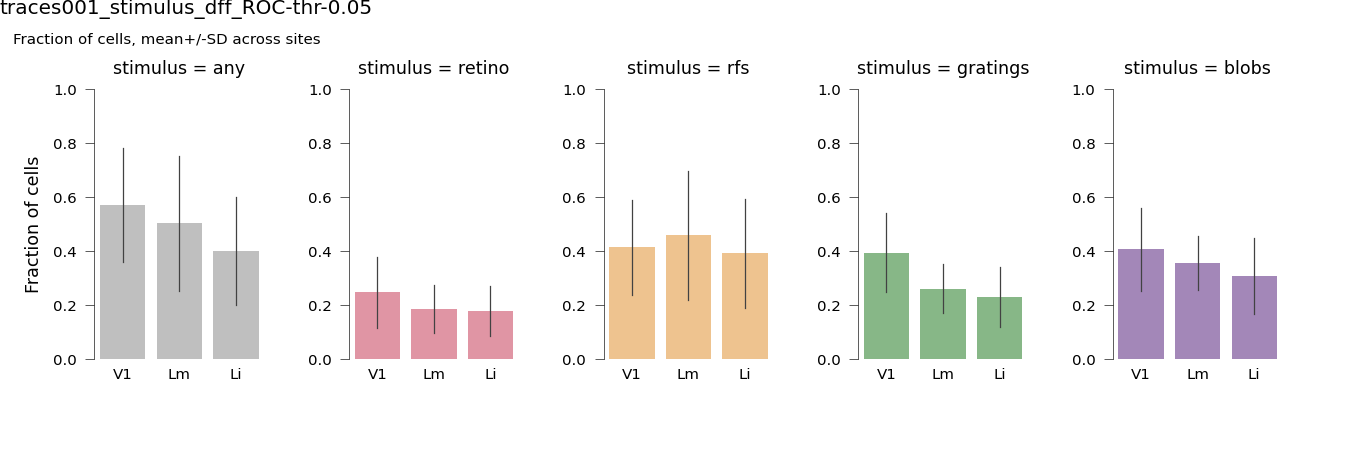

/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/julianarhee/aggregate-visual-areas/data-stats/figures_v2 fraction_responsive_test-ROC-thr-0
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/julianarhee/aggregate-visual-areas/FIGURES/fraction_responsive_test-ROC-thr-0_thr-min-10-cells.svg


In [60]:
%matplotlib notebook
e_colors = {'retino': 'crimson', 'rfs': 'darkorange', 
            'gratings': 'green', 'blobs': 'indigo',
            'any': 'gray'}

fg = sns.FacetGrid(col='stimulus', data=COUNTS_thr, height=2.5, aspect=0.6,
                  col_order=['any', 'retino', 'rfs', 'gratings', 'blobs'],
                  hue='stimulus', palette=e_colors) #'colorblind')
fg.map(sns.barplot, 'visual_area', 'fraction_responsive', 
         order=visual_areas, ci='sd', alpha=0.5, errwidth=0.5)

sns.despine(bottom=True)

for ai, ax in enumerate(fg.axes.flat):
    ax.set_xlabel('')
    ax.tick_params(which='both', axis='x', size=0)
    ax.tick_params(labelleft=True)
    ax.set_ylim([0, 1])
    if ai==0 or ai==1:
        ax.set_ylabel('Fraction of cells')
    #ax.set_box_aspect(2)
pl.subplots_adjust(left=0.07, right=0.95, bottom=0.2, top=0.8, wspace=0.5)
fg.fig.text(0.01, 0.9, 'Fraction of cells, mean+/-SD across sites')

pplot.label_figure(fg.fig, data_id)
figname = 'fraction_responsive_test-%s-thr-%i' % (gratings_test, gratings_thr)
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(dst_dir, figname)

FIGDIR = os.path.join(aggregate_dir, 'FIGURES')
pl.savefig(os.path.join(FIGDIR, '{}_thr-min-{}-cells.svg'.format(figname, min_ncells)))
print(os.path.join(FIGDIR, '{}_thr-min-{}-cells.svg'.format(figname, min_ncells)))

In [61]:
COUNTS_thr

,visual_area,datakey,n_responsive,n_total,fraction_responsive,stimulus
0,Li,20190522_JC089_fov1,10,28,0.357143,rfs
1,Li,20190527_JC092_fov3,65,118,0.550847,rfs
2,Li,20190528_JC092_fov1,37,47,0.787234,rfs
3,Li,20190602_JC091_fov1,103,197,0.522843,rfs
4,Li,20190612_JC099_fov1,54,164,0.329268,rfs
...,...,...,...,...,...,...
60,V1,20190617_JC097_fov1,327,438,0.746575,any
61,V1,20190622_JC085_fov1,243,312,0.778846,any
62,V1,20191004_JC110_fov2,92,363,0.253444,any
63,V1,20191006_JC110_fov1,185,391,0.473146,any


# Select example cells spanning ALL stimuli

In [33]:
fit_thr=0.5; n_bootstrap_iters=1000; n_resamples=20;
assigned_cells, _ = select_assigned_cells(cells0, sdata, 
                                                      experiments=['gratings'])
ori_fit_desc = gutils.get_fit_desc(response_type=response_type, 
                                responsive_test=gratings_test, 
                                n_stds=n_stds, responsive_thr=gratings_thr, 
                                n_bootstrap_iters=n_bootstrap_iters, 
                                n_resamples=n_resamples)
gdata, missing_ = gutils.aggregate_ori_fits(assigned_cells, 
                                traceid=traceid, fit_desc=ori_fit_desc, 
                                return_missing=True) 
print(missing_)

/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/utils/gratings_utils.py:174: RuntimeWarning: invalid value encountered in sqrt
  gfit = np.mean(bootr['results']['r2']) * (1-iqr) * np.sqrt(r2_comb)


['Lm_20191111_JC120_fov1']


In [308]:
gof_thr=0.25
gratings_ = gdata[gdata['gof']>=gof_thr][['visual_area', 'datakey', 'cell']]\
            .drop_duplicates()
gratings_.groupby(['visual_area']).count()

,datakey,cell
visual_area,,
Li,224,224
Lm,547,547
V1,621,621


In [309]:
rf_cells, rf_meta = select_assigned_cells(cells0, sdata, 
                                          experiments=['rfs', 'rfs10']) 
# Drop repeat FOVs by selecting those with most RF fits
do_spherical_correction=False
rf_fit_desc = rfutils.get_fit_desc(response_type=response_type, 
                               do_spherical_correction=do_spherical_correction)
rfdata = rfutils.aggregate_rfdata(rf_meta, rf_cells, 
                            fit_desc=rf_fit_desc, reliable_only=False)
# Combined rfs5/rfs10
RFS = rfutils.average_rfs_select(rfdata)

# Get RF cells
rfs_ = rfdata_avg[['visual_area', 'datakey', 'cell']]\
            .drop_duplicates()
rfs_.groupby(['visual_area']).count()

N dpaths: 65, N unfit: 0
N datasets included: 65, N sessions excluded: 4


,datakey,cell
visual_area,,
Li,450,450
Lm,422,422
V1,654,654


In [310]:
# Get blobs
trial_epoch='plushalf'
responsive_test='ROC'
responsive_thr=0.05
BLOBS = aggr.get_aggregate_data('blobs', traceid=traceid, 
                      response_type=response_type, epoch=trial_epoch,
                      responsive_test=responsive_test, 
                      responsive_thr=responsive_thr, n_stds=n_stds)
objects_ = BLOBS[['visual_area', 'datakey', 'cell']].drop_duplicates()

/n/coxfs01/julianarhee/aggregate-visual-areas/dataset_info_assigned.pkl
Segmentation: missing 3 dsets
['blobs']
...loading: /n/coxfs01/julianarhee/aggregate-visual-areas/data-stats/aggr_blobs_trialmeans_traces001_ROC-thr-0.05_dff_plushalf.pkl
*Warning* <20190314_JC070_fov1> More than 1 pos? x: [0.0 -15.0], y: [0.0 -5.0]


In [311]:
# retinodata
retino_thr=0.01
retino_delay=1
retinodata = aggr.get_aggregate_retinodata(traceid=traceid, 
                        mag_thr=retino_thr, delay_thr=retino_delay)
retino_ = aggr.get_responsive_retino(retinodata, mag_thr=retino_thr)


In [312]:
f_=[]
for (va, dk), curr_rfs in rfs_.groupby(['visual_area', 'datakey']):
    cells_1 = curr_rfs['cell'].unique()
    # Get gratings cells
    curr_grat = gratings_[(gratings_.visual_area==va) & (gratings_.datakey==dk)].copy()
    cells_2 = curr_grat['cell'].unique()
    # Get cells in both
    common_ = np.intersect1d(cells_1, cells_2)
    # Get blobs
    curr_obj = objects_[(objects_.visual_area==va) & (objects_.datakey==dk)].copy()
    cells_3 = curr_obj['cell'].unique()
    common_1 = np.intersect1d(common_, cells_3)
    # Get retino
    curr_ret = retino_[(retino_.visual_area==va) & (retino_.datakey==dk)].copy()
    cells_4 = curr_ret['cell'].unique()
    common_2 = np.intersect1d(common_1, cells_4)
    
    final_cells = curr_rfs[curr_rfs['cell'].isin(common_2)]
    f_.append(final_cells)
ccounts = pd.concat(f_)
ccounts.shape

(180, 3)

In [313]:
ccounts.groupby(['visual_area']).count()

,datakey,cell
visual_area,,
Li,15,15
Lm,44,44
V1,121,121


In [314]:
ccounts[ccounts['visual_area']=='Li']

,visual_area,datakey,cell
61,Li,20190602_JC091_fov1,33.0
66,Li,20190602_JC091_fov1,39.0
67,Li,20190602_JC091_fov1,41.0
68,Li,20190602_JC091_fov1,42.0
69,Li,20190602_JC091_fov1,43.0
72,Li,20190602_JC091_fov1,47.0
74,Li,20190602_JC091_fov1,50.0
81,Li,20190602_JC091_fov1,64.0
85,Li,20190602_JC091_fov1,70.0
88,Li,20190602_JC091_fov1,73.0


In [315]:
va='Li'
#dk='20190602_JC091_fov1'

currd=[]
for dk, g in ccounts[(ccounts['visual_area']=='Li')].groupby(['datakey']):
    curr_rois = g['cell'].unique()
    nd = NDATA[(NDATA.visual_area=='Li') & (NDATA.datakey==dk)
                & (NDATA['cell'].isin(curr_rois))].copy()
    currd.append(nd)
bdata = pd.concat(currd, axis=0)
bdata.shape

(22488, 6)

In [316]:
# np.reshape(bdata.groupby(['config'])['response'].mean().index.tolist(), (10, 5)).T

In [317]:
li_ccounts = ccounts[(ccounts['visual_area']=='Li')].copy()

<IPython.core.display.Javascript object>


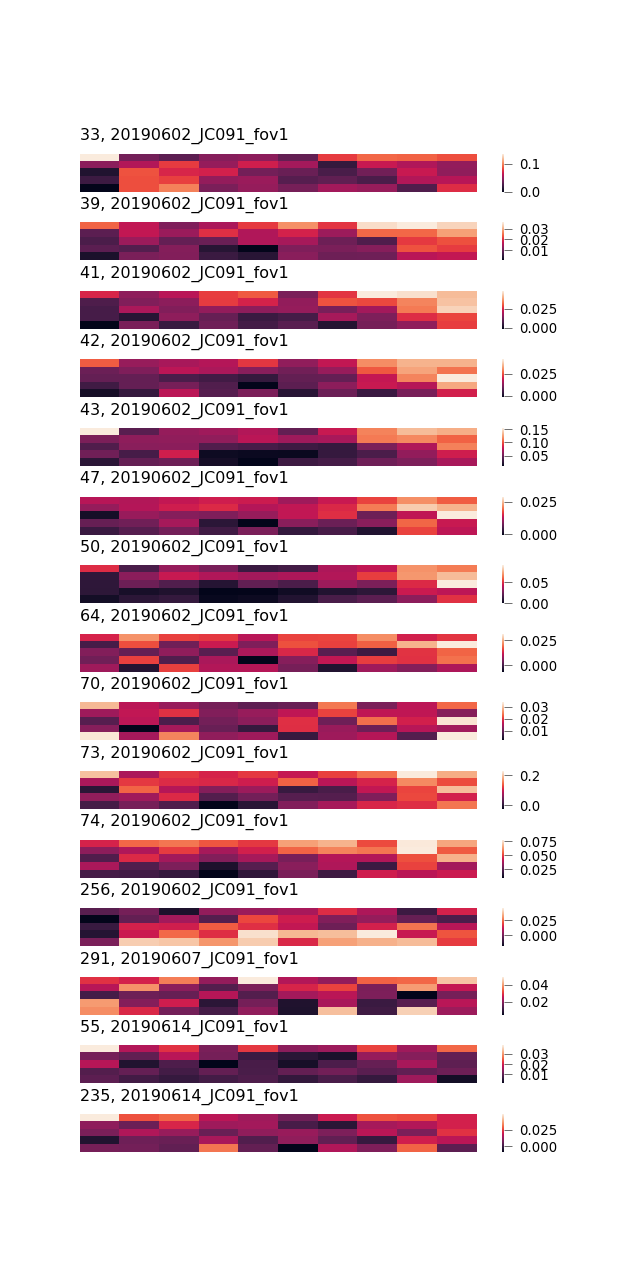

In [318]:
ncells_pass = li_ccounts.shape[0]
fig, axn = pl.subplots(ncells_pass, 1, figsize=(4,8))
for ai, ((dk, ri), df_) in enumerate(bdata.groupby(['datakey', 'cell'])):
    obj_map = np.reshape(df_.groupby(['config'])['response'].mean().values, (10, 5)).T
    ax=axn[ai]
    sns.heatmap(obj_map, ax=ax)
    ax.set_title('%i, %s' % (ri, dk), loc='left')
    ax.axis('off')
pl.subplots_adjust(wspace=0.5, hspace=0.8, bottom=0.1)

In [204]:
sdf = hutils.get_stimuli(dk, 'blobs')


In [337]:
assigned_cells[(assigned_cells.datakey=='20190607_JC091_fov1')]['cell'].unique()

array([512., 513., 514., 522.,  11.,  12.,  13.,  14.,  15.,  16.,  17.,
        18.,  19.,  20.,  21.,  22.,  23.,  24.,  25.,  26.,  27.,  28.,
        44.,  50.,  51., 523., 524.,  92.,  93.,  94.,  95.,  96.,  97.,
        98.,  99., 100., 101., 102., 103., 104., 105., 106., 107., 108.,
       109., 110., 111., 112., 113., 114., 115., 116., 118., 119., 120.,
       121., 122., 123., 124., 125., 126., 127., 128., 129., 130., 131.,
       132., 133., 134., 135., 136., 137., 138., 139., 140., 141., 142.,
       143., 144., 145., 146., 153., 154., 155., 156., 157., 158., 159.,
       160., 161., 162., 163., 164., 165., 166., 167., 168., 169., 170.,
       171., 172., 173., 174., 175., 176., 177., 178., 179., 180., 181.,
       182., 183., 184., 185., 186., 187., 188., 189., 190., 191., 192.,
       193., 194., 195., 196., 197., 198., 199., 200., 201., 202., 203.,
       204., 205., 206., 207., 208., 209., 210., 211., 212., 213., 214.,
       215., 216., 217., 218., 219., 220., 221., 22

In [361]:
va='Li'
# dk = '20190614_JC091_fov1' #'20190602_JC091_fov1'
# rid = 304 #234 #43 #234
# dk = '20190602_JC091_fov1' #'20190602_JC091_fov1'
# rid = 51 #43 #43 #234
dk = '20190614_JC091_fov1' #'20190602_JC091_fov1'
rid = 343 #234 #43 #234

gd = gdata[(gdata.visual_area==va) & (gdata.datakey==dk) & (gdata['cell']==rid)].copy()
print('gratings, %.2f' % gd['gof'].max())

bd = BLOBS[(BLOBS.visual_area==va) & (BLOBS.datakey==dk) & (BLOBS['cell']==rid)].copy()
print('blobs, %.2f' % bd.dropna().groupby(['config']).mean()['response'].max())

rd = RFS[(RFS.visual_area==va) & (RFS.datakey==dk) & (RFS['cell']==rid)].copy()
print('RF: r2=%.2f' % rd['r2'].max())

retd = retino_[(retino_.visual_area==va) & (retino_.datakey==dk) & (retino_['cell']==rid)]
print(retd[['mag_az', 'mag_el']].max(axis=1))

gratings, nan
blobs, 0.09
RF: r2=0.94
Series([], dtype: float64)


In [362]:
RFS[(RFS.visual_area==va) & (RFS.datakey==dk) & (RFS['cell']==rid)]

,datakey,animalid,session,cell,x0,y0,fwhm_x,fwhm_y,theta,r2,...,ratio_xy,theta_c,theta_Mm_deg,major_axis,minor_axis,anisotropy,theta_Mm_c,aniso_index,visual_area,experiment
339,20190614_JC091_fov1,JC091,20190614,343.0,44.939706,-18.556217,26.652976,35.422658,1.320921,0.938588,...,0.752427,1.320921,165.683206,15.073471,11.341692,0.141274,-0.249875,-0.071405,Li,rfs10


In [363]:
rd.columns

Index(['datakey', 'animalid', 'session', 'cell', 'x0', 'y0', 'fwhm_x',
       'fwhm_y', 'theta', 'r2', 'fovnum', 'std_x', 'std_y', 'fwhm_avg',
       'std_avg', 'area', 'fx', 'fy', 'ratio_xy', 'theta_c', 'theta_Mm_deg',
       'major_axis', 'minor_axis', 'anisotropy', 'theta_Mm_c', 'aniso_index',
       'visual_area', 'experiment'],
      dtype='object')

In [132]:
dk = '20190617_JC097_fov1'
session, animalid, fovn = hutils.split_datakey_str(dk)
fov='FOV%i_zoom2p0x' % fovn
try:
    roiid = roiutils.get_roiid_from_traceid(animalid, session, fov, 
                                            traceid=traceid)
except Exception as e:
    print(e)
    print("[%s] Unable to get roiid (%s)" % (dk, traceid))
    roiid=None
# Select best retino run (if there are multiple)
all_retinos = pd.DataFrame(retutils.get_average_mag_across_pixels(dk))
retinorun = all_retinos.loc[all_retinos[1].idxmax()][0]
retinoid, RETID = retutils.load_retino_analysis_info(dk, use_pixels=False, roiid=roiid)
print(retinorun, retinoid)

retino_run1 analysis002


In [180]:
scaninfo = retutils.get_protocol_info(dk, run=retinorun)
scaninfo.keys()

dict_keys(['acquisition', 'acquisition_base_dir', 'animal_id', 'base_filename', 'frame_idxs', 'frame_nums', 'frame_rate', 'frame_tstamps_sec', 'lines_per_frame', 'nchannels', 'ntiffs', 'nvolumes', 'params_path', 'pixels_per_line', 'raw_simeta_path', 'rawtiff_dir', 'roi_dir', 'rootdir', 'run', 'session', 'slices', 'trace_dir', 'volume_rate', 'stimulus', 'trials'])

In [170]:
importlib.reload(retutils)

<module 'analyze2p.retinotopy.utils' from '/home/julianarhee/Repositories/rat-2p-area-characterizations/analyze2p/retinotopy/utils.py'>

In [169]:
RETID['PARAMS']['downsample_factor']


'2'

In [266]:
soma_traces = retutils.load_roi_traces(dk, run=retinorun,
                 analysisid=retinoid, trace_type='corrected', 
                    detrend_after_average=True, temporal_ds=7)


In [268]:
dff_soma = dict((cond, (tdf - tdf.mean(axis=0))/ tdf.mean(axis=0)) \
                for cond, tdf in soma_traces.items())


In [152]:
mag_thr=0.02
delay_thr=1.0
va='V1'

assigned_, ret_meta = aggr.select_assigned_cells(cells0, 
                                                    sdata, experiments=['retino'])
curr_cells = assigned_[(assigned_.visual_area==va) 
                     & (assigned_.datakey==dk)]
retdf = retutils.get_retino_fft(dk, curr_cells=curr_cells, 
                        mag_thr=mag_thr, delay_thr=delay_thr,
                        create_new=False,use_pixels=False)
# Sort cels by mag ratio
sorted_mags = retdf[['mag_az', 'mag_el']].mean(axis=1).sort_values(ascending=False)
sorted_mags.iloc[0:10]

In [194]:
# Convert x-axis to SEC
frames_tsec = dff_soma['right'].index.to_numpy()*(1./scaninfo['stimulus']['frame_rate'])

cycles_tsec = scaninfo['stimulus']['cycle_start_ixs']*(1./scaninfo['stimulus']['frame_rate'])

<IPython.core.display.Javascript object>


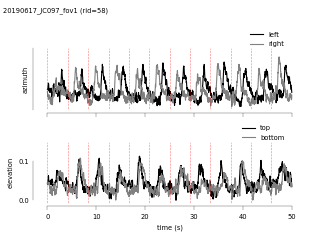

left
right
top
bottom


In [271]:
cond_colors = {'top': 'black', 'bottom': 'grey', 
               'left': 'black', 'right': 'grey'}
cond_dict = {'azimuth': ['left', 'right'],
             'elevation': ['top', 'bottom']}
lw=1

fig, axn = pl.subplots(2, 1, sharex=True, sharey=False, figsize=(4,3))
for ai, (axis_label, cond_pair) in enumerate(cond_dict.items()):
    ax=axn[ai]
    for cond, cond_color in zip(cond_pair, [cond_colors[k] for k in cond_pair]):
        print(cond)
        vs = dff_soma[cond][rid].values
        if min(vs) < 0:
            vs -= np.min(dff_soma[cond][rid].values)
        ax.plot(frames_tsec, vs, lw=lw, color=cond_color, label=cond)
        ax.set_ylabel(axis_label)
    ax.legend(bbox_to_anchor=(0.95,.92), loc='lower right', frameon=False)
    ax.set_ylim([-0.01, 0.15])
    if ai==1:
        ax.set_yticks(np.linspace(0, 0.1, 2))
        ax.set_yticklabels(np.linspace(0, 0.1, 2))
        ax.tick_params(which='both', axis='y', size=0)
    else:
        ax.set_yticks([])
        ax.set_yticklabels([])
for ax in axn.flat:
    for cyc in cycles_tsec:
        ax.axvline(x=cyc, ls=':', c='red', lw=0.5)
axn[1].set_xlabel('time (s)')
sns.despine(trim=True, offset=2)

pl.subplots_adjust(bottom=0.15, hspace=0.5, top=0.8, right=0.95, left=0.11)
fig.text(0.01, 0.95, '%s (rid=%i)' % (dk, rid))

pl.savefig(os.path.join(FIGDIR, 'examples', 'movingbar__%s_%s.svg' % (va, dk)))


<IPython.core.display.Javascript object>


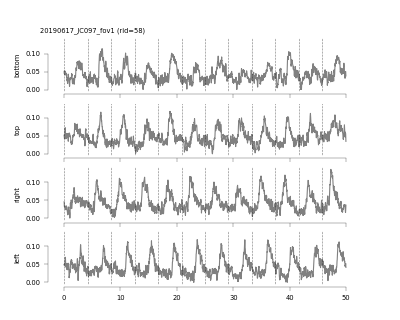

Text(0.1, 0.9, '20190617_JC097_fov1 (rid=58)')

In [203]:
rid = 58
retino_conds = dff_soma.keys()
fig, axn = pl.subplots(len(retino_conds), 1, sharex=True, sharey=True)
for ax, cond in zip(axn.flat, retino_conds):
    vs = dff_soma[cond][rid].values
    if min(vs) < 0:
        vs -= 0 #np.min(dff_soma[cond][rid].values)/4.
    ax.plot(frames_tsec, vs, lw=1, color='gray')
    ax.set_ylabel(cond)
for ax in axn.flat:
    for cyc in cycles_tsec:
        ax.axvline(x=cyc, ls=':', c='k', lw=0.5)
    sns.despine(trim=True, offset=2, ax=ax)

fig.text(0.1, 0.9, '%s (rid=%i)' % (dk, rid))

In [243]:
np.linspace(0, 0.1, 2)

array([0. , 0.1])

In [265]:
if not os.path.exists(os.path.join(FIGDIR, 'examples')):
    os.makedirs(os.path.join(FIGDIR, 'examples'))